# Question 4: Implementing the image denoising problem

/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121

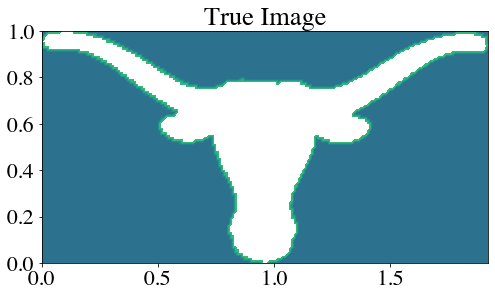

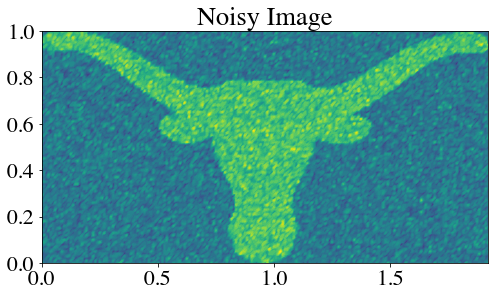

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging
from unconstrainedMinimization import InexactNewtonCG
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times'})

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)

noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly), 200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(UserExpression):
    def __init__(self, Lx, Ly, data, **kwargs):
        super().__init__(kwargs)
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]
        
    def value_shape(self):
        return ()

trueImage  = Image(Lx, Ly, data, element=V.ufl_element())
noisyImage = Image(Lx, Ly, data+noise, element=V.ufl_element())

u_true  = interpolate(trueImage, V)
u_0     = interpolate(noisyImage, V)

vmin = np.min(u_0.vector().get_local())
vmax = np.max(u_0.vector().get_local())

plt.figure(figsize=[8,8])
plot(u_true, title="True Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_true.pdf")
plt.figure(figsize=[8,8])
plot(u_0, title="Noisy Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_Noisy.pdf")
plt.show()

# Part (a): Solving using Tikhonov (TN) regularization

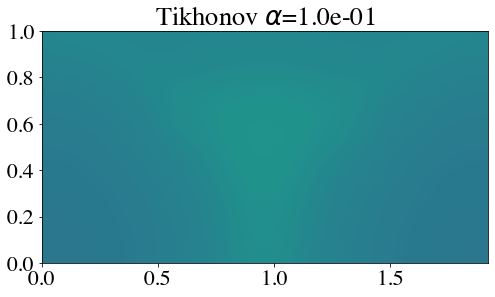

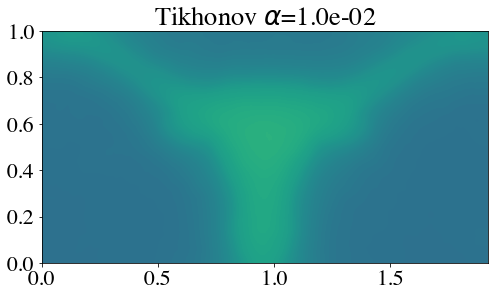

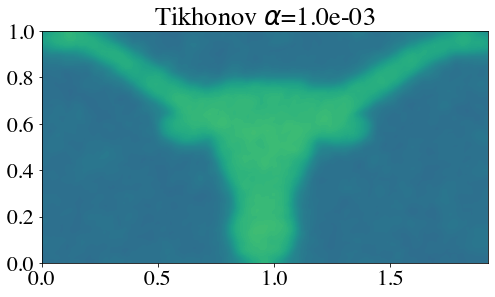

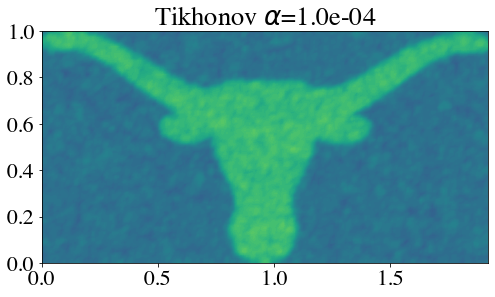

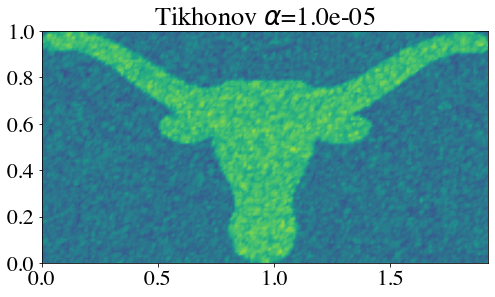

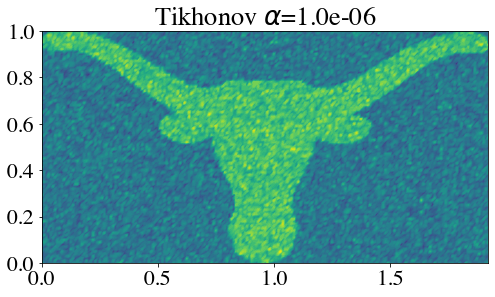

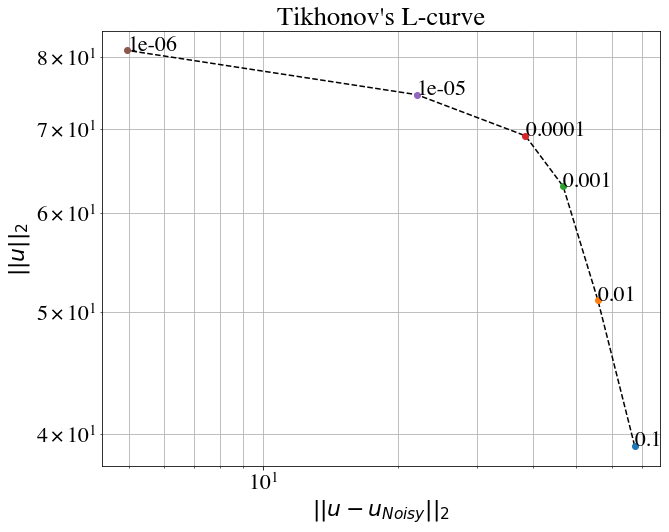

In [2]:
# Denoising using TN regularization using linear solve

# Defining functional forms
def TN_functions(alpha_val):
    """ linear form - solve lhs == rhs """
    alpha = Constant(alpha_val)
    u_trial = TrialFunction(V)
    u_test  = TestFunction(V)
    var_F_tn= (u_trial - u_0)*u_test*dx + alpha*inner(grad(u_trial), grad(u_test))*dx
    return lhs(var_F_tn), rhs(var_F_tn)

# TN regularization
alphas = np.logspace(-1,-6,6)
res_tn_norm = []
u_tn_norm   = []
u_tn_list   = []

for alpha in alphas:
    u_tn = Function(V)
    # linear solve
    a_tn, L_tn = TN_functions(alpha)
    solve(a_tn==L_tn, u_tn)

    # Misfit
    res_tn_norm.append(np.linalg.norm(u_tn.vector()[:] - u_0.vector()[:]))
    u_tn_norm.append(np.linalg.norm(u_tn.vector()[:]))
    u_tn_list.append(u_tn.copy())
    
    #plotting the image
    plt.figure(figsize=(8,8))
    plot(u_tn, title="Tikhonov $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)
    plt.savefig("Q4_TN_%.1e_.pdf" %(alpha))

# plot l-curve
fig,ax = plt.subplots(figsize=(10,8))
plt.loglog(res_tn_norm, u_tn_norm,'k--')
for i, txt in enumerate(alphas):
    ax.loglog(res_tn_norm[i], u_tn_norm[i],'o')
    ax.annotate(txt, (res_tn_norm[i], u_tn_norm[i]))

plt.grid(True, which="both")
plt.xlabel(r'$||u - u_{Noisy}||_2$')
plt.ylabel(r'$||u||_2$')
plt.title("Tikhonov's L-curve")
plt.savefig("Q4_TN_lcurve.pdf") 

## Optimal $\alpha$ is close to $10^{-3}$ since it is the point of the maximum curvature in the L-curve. Moreover, by visual inspection, it is clear that the image is free of oscillations without much diffusion for this value of regularization parameter.

# Part (b): Solving using Total variation regularization

In [3]:
# Define solver
solver = InexactNewtonCG()
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-9
solver.parameters["gdu_tolerance"] = 1e-18
solver.parameters["max_iter"] = 5000
solver.parameters["c_armijo"] = 1e-5
solver.parameters["print_level"] = 1
solver.parameters["max_backtracking_iter"] = 10

Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    4.114996e-01    1.762820e-02   -1.244924e-01    1.000000e+00    5.000000e-01       1
  1    4.113994e-01    1.679678e-03   -1.998188e-04    1.000000e+00    5.000000e-01       2
  2    4.113992e-01    2.768329e-04   -3.836712e-07    1.000000e+00    4.873592e-01       1
  3    4.113992e-01    2.153250e-05   -4.511491e-08    1.000000e+00    1.978541e-01       2
  4    4.113992e-01    6.447811e-07   -2.028117e-10    1.000000e+00    5.518021e-02       3
  5    4.113992e-01    2.410054e-09   -5.147674e-14    1.000000e+00    9.548655e-03       4
Norm of the gradient less than tolerance
Inexact Newton CG converged in  5 nonlinear iterations and  857 linear iterations.
Final norm of the gradient 2.410054389228049e-09
Value of the cost functional 0.4113992084764307
Using Symbolic Differentia

 64    9.515613e-02    3.715417e-03   -1.049359e-02    7.812500e-03    5.000000e-01       1
 65    9.513034e-02    3.672207e-03   -1.065885e-02    7.812500e-03    5.000000e-01       1
 66    9.512952e-02    3.648855e-03   -9.034272e-03    1.562500e-02    5.000000e-01       1
 67    9.512016e-02    3.529973e-03   -1.157500e-02    3.125000e-02    5.000000e-01       1
 68    9.499093e-02    3.460108e-03   -1.192748e-02    3.125000e-02    5.000000e-01       1
 69    9.496844e-02    3.360170e-03   -1.386423e-02    3.125000e-02    5.000000e-01       1
 70    9.479250e-02    3.299151e-03   -1.184281e-02    3.125000e-02    5.000000e-01       1
 71    9.471303e-02    3.238079e-03   -1.351189e-02    1.562500e-02    5.000000e-01       1
 72    9.465803e-02    3.215568e-03   -9.717743e-03    1.562500e-02    5.000000e-01       1
 73    9.463427e-02    3.158581e-03   -1.058965e-02    1.562500e-02    5.000000e-01       1
 74    9.456758e-02    3.137945e-03   -9.641996e-03    1.562500e-02    5.000000e

154    9.332524e-02    2.148276e-03   -6.325398e-03    7.812500e-03    5.000000e-01       1
155    9.331636e-02    2.105525e-03   -6.690401e-03    7.812500e-03    5.000000e-01       1
156    9.330485e-02    2.133966e-03   -6.298799e-03    7.812500e-03    5.000000e-01       1
157    9.329609e-02    2.091063e-03   -6.663616e-03    7.812500e-03    5.000000e-01       1
158    9.328472e-02    2.119900e-03   -6.272499e-03    7.812500e-03    5.000000e-01       1
159    9.327608e-02    2.076843e-03   -6.637125e-03    7.812500e-03    5.000000e-01       1
160    9.326486e-02    2.106070e-03   -6.246501e-03    7.812500e-03    5.000000e-01       1
161    9.325633e-02    2.062859e-03   -6.610933e-03    7.812500e-03    5.000000e-01       1
162    9.324525e-02    2.092471e-03   -6.220806e-03    7.812500e-03    5.000000e-01       1
163    9.323684e-02    2.049104e-03   -6.585040e-03    7.812500e-03    5.000000e-01       1
164    9.322590e-02    2.079098e-03   -6.195419e-03    7.812500e-03    5.000000e

244    9.261290e-02    1.677807e-03   -5.458569e-03    7.812500e-03    4.808702e-01       1
245    9.260761e-02    1.627352e-03   -5.812683e-03    7.812500e-03    4.870877e-01       1
246    9.260049e-02    1.670183e-03   -5.444167e-03    7.812500e-03    4.797079e-01       1
247    9.259525e-02    1.619546e-03   -5.797720e-03    7.812500e-03    4.859796e-01       1
248    9.258821e-02    1.662647e-03   -5.429549e-03    7.812500e-03    4.785560e-01       1
249    9.258301e-02    1.611830e-03   -5.782541e-03    7.812500e-03    4.848821e-01       1
250    9.257603e-02    1.655200e-03   -5.414733e-03    7.812500e-03    4.774146e-01       1
251    9.257089e-02    1.604202e-03   -5.767169e-03    7.812500e-03    4.837949e-01       1
252    9.256398e-02    1.647840e-03   -5.399743e-03    7.812500e-03    4.762835e-01       1
253    9.255889e-02    1.596661e-03   -5.751630e-03    7.812500e-03    4.827181e-01       1
254    9.255205e-02    1.640566e-03   -5.384607e-03    7.812500e-03    4.751628e

334    9.216983e-02    1.406927e-03   -4.830792e-03    7.812500e-03    4.374586e-01       1
335    9.216665e-02    1.348383e-03   -5.165133e-03    7.812500e-03    4.460380e-01       1
336    9.216233e-02    1.402207e-03   -4.819416e-03    7.812500e-03    4.366593e-01       1
337    9.215919e-02    1.343484e-03   -5.153366e-03    7.812500e-03    4.452892e-01       1
338    9.215491e-02    1.397528e-03   -4.808149e-03    7.812500e-03    4.358654e-01       1
339    9.215181e-02    1.338627e-03   -5.141707e-03    7.812500e-03    4.445456e-01       1
340    9.214757e-02    1.392889e-03   -4.796988e-03    7.812500e-03    4.350767e-01       1
341    9.214451e-02    1.333809e-03   -5.130155e-03    7.812500e-03    4.438073e-01       1
342    9.214032e-02    1.388291e-03   -4.785933e-03    7.812500e-03    4.342931e-01       1
343    9.213728e-02    1.329031e-03   -5.118709e-03    7.812500e-03    4.430740e-01       1
344    9.213314e-02    1.383730e-03   -4.774982e-03    7.812500e-03    4.335146e

424    9.189971e-02    1.225912e-03   -4.409341e-03    7.812500e-03    4.055075e-01       1
425    9.189770e-02    1.159183e-03   -4.726677e-03    7.812500e-03    4.163569e-01       1
426    9.189498e-02    1.222445e-03   -4.401669e-03    7.812500e-03    4.048667e-01       1
427    9.189298e-02    1.155528e-03   -4.718637e-03    7.812500e-03    4.157677e-01       1
428    9.189028e-02    1.218995e-03   -4.394051e-03    7.812500e-03    4.042280e-01       1
429    9.188831e-02    1.151890e-03   -4.710652e-03    7.812500e-03    4.151807e-01       1
430    9.188563e-02    1.215563e-03   -4.386486e-03    7.812500e-03    4.035912e-01       1
431    9.188367e-02    1.148269e-03   -4.702719e-03    7.812500e-03    4.145957e-01       1
432    9.188102e-02    1.212147e-03   -4.378973e-03    7.812500e-03    4.029562e-01       1
433    9.187908e-02    1.144664e-03   -4.694840e-03    7.812500e-03    4.140127e-01       1
434    9.187646e-02    1.208746e-03   -4.371512e-03    7.812500e-03    4.023232e

514    9.172291e-02    1.083407e-03   -4.104350e-03    7.812500e-03    3.780726e-01       1
515    9.172147e-02    1.007726e-03   -4.404973e-03    7.812500e-03    3.914100e-01       1
516    9.171965e-02    1.080525e-03   -4.098644e-03    7.812500e-03    3.774916e-01       1
517    9.171821e-02    1.004635e-03   -4.398833e-03    7.812500e-03    3.908890e-01       1
518    9.171640e-02    1.077657e-03   -4.092854e-03    7.812500e-03    3.769123e-01       1
519    9.171496e-02    1.001559e-03   -4.392583e-03    7.812500e-03    3.903700e-01       1
520    9.171317e-02    1.074804e-03   -4.086941e-03    7.812500e-03    3.763348e-01       1
521    9.171174e-02    9.984973e-04   -4.386217e-03    7.812500e-03    3.898529e-01       1
522    9.170996e-02    1.071966e-03   -4.080918e-03    7.812500e-03    3.757591e-01       1
523    9.170855e-02    9.954511e-04   -4.379774e-03    7.812500e-03    3.893379e-01       1
524    9.170679e-02    1.069144e-03   -4.074836e-03    7.812500e-03    3.751855e

604    9.160136e-02    9.700699e-04   -3.795671e-03    7.812500e-03    3.542564e-01       1
605    9.160028e-02    8.850930e-04   -4.073143e-03    7.812500e-03    3.703715e-01       1
606    9.159917e-02    9.678936e-04   -3.787241e-03    7.812500e-03    3.537778e-01       1
607    9.159810e-02    8.827090e-04   -4.063930e-03    7.812500e-03    3.699558e-01       1
608    9.159701e-02    9.657300e-04   -3.778627e-03    7.812500e-03    3.533010e-01       1
609    9.159594e-02    8.803376e-04   -4.054501e-03    7.812500e-03    3.695421e-01       1
610    9.159486e-02    9.635790e-04   -3.769807e-03    7.812500e-03    3.528261e-01       1
611    9.159380e-02    8.779787e-04   -4.044829e-03    7.812500e-03    3.691304e-01       1
612    9.159273e-02    9.614406e-04   -3.760754e-03    7.812500e-03    3.523531e-01       1
613    9.159167e-02    8.756322e-04   -4.034883e-03    7.812500e-03    3.687205e-01       1
614    9.159062e-02    9.593147e-04   -3.751439e-03    7.812500e-03    3.518819e

 14    4.426650e-02    7.345621e-04   -2.546472e-03    6.250000e-02    3.216534e-01       1
 15    4.425712e-02    6.697176e-04   -2.805952e-03    6.250000e-02    3.222926e-01       1
 16    4.421780e-02    6.756773e-04   -2.449213e-03    6.250000e-02    3.077386e-01       1
 17    4.420857e-02    6.185647e-04   -2.705425e-03    6.250000e-02    3.091048e-01       1
 18    4.416891e-02    6.234436e-04   -2.287989e-03    6.250000e-02    2.957527e-01       1
 19    4.416615e-02    5.753455e-04   -2.421057e-03    6.250000e-02    2.969167e-01       1
 20    4.413841e-02    5.816050e-04   -2.277222e-03    6.250000e-02    2.852334e-01       1
 21    4.413207e-02    5.360710e-04   -2.458000e-03    6.250000e-02    2.867809e-01       1
 22    4.410218e-02    5.460162e-04   -2.118071e-03    6.250000e-02    2.753260e-01       1
 23    4.410210e-02    5.033210e-04   -2.247445e-03    6.250000e-02    2.778682e-01       1
 24    4.408099e-02    5.202326e-04   -2.095078e-03    6.250000e-02    2.667833e

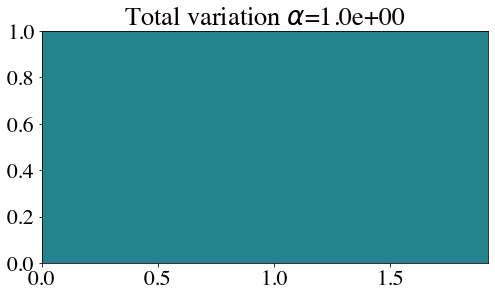

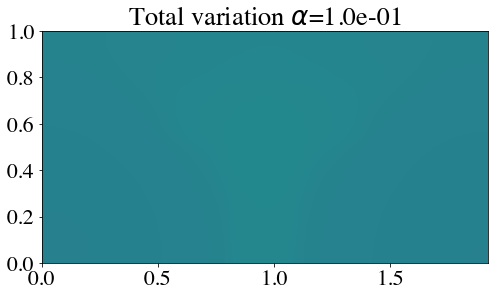

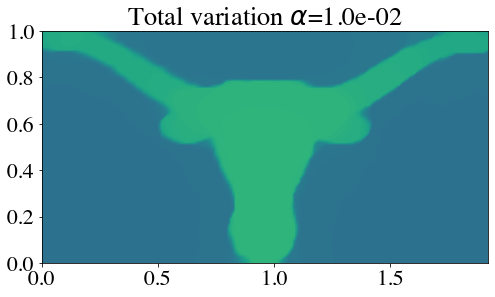

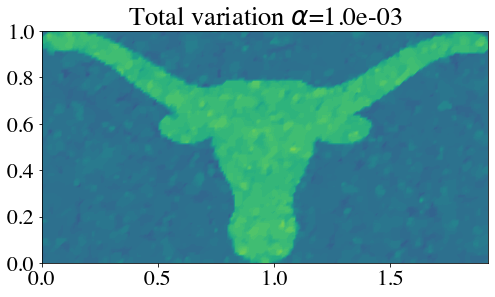

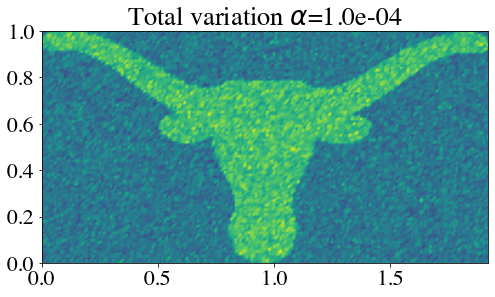

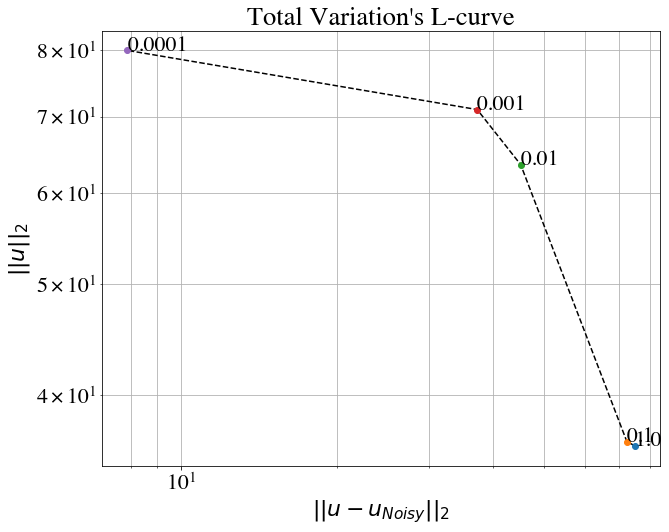

In [5]:
# Denoising using TV regularization using linear solve

# Defining functional forms
def TV_functions(alpha_val,delta_val,u_func):
    """ linear form - solve lhs == rhs """
    alpha = Constant(alpha_val) #Regularization parameters
    delta = Constant(delta_val) #Added term in the regularization
    F_tv  = Constant(0.5) * (u_func - u_0)**2 * dx + alpha * sqrt(inner(grad(u_func), grad(u_func)) + delta)*dx
    return F_tv
    
# TN regularization
alphas = np.logspace(0,-4,5)
delta  = 0.01
res_tv_norm = []
u_tv_norm   = []
u_tv_list   = []

for alpha in alphas:
    u_tv = Function(V)
    F_tv = TV_functions(alpha,delta,u_tv)
    solver.solve(F_tv, u_tv)

    # Misfit
    res_tv_norm.append(np.linalg.norm(u_tv.vector()[:] - u_0.vector()[:]))
    u_tv_norm.append(np.linalg.norm(u_tv.vector()[:]))
    u_tv_list.append(u_tv.copy())
    
    #plotting the image
    plt.figure(figsize=(8,8))
    plot(u_tv, title="Total variation $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)
    plt.savefig("Q4_TN_%.1e_.pdf" %(alpha))

# plot l-curve
fig,ax = plt.subplots(figsize=(10,8))
plt.loglog(res_tv_norm, u_tv_norm,'k--')
for i, txt in enumerate(alphas):
    ax.loglog(res_tv_norm[i], u_tv_norm[i],'o')
    ax.annotate(txt, (res_tv_norm[i], u_tv_norm[i]))

plt.grid(True, which="both")
plt.xlabel(r'$||u - u_{Noisy}||_2$')
plt.ylabel(r'$||u||_2$')
plt.title("Total Variation's L-curve")
plt.savefig("Q4_TV_lcurve.pdf") 

## It turns out that the optimal $\alpha$ for this case turns out to be $10^{-3}$.

# Effect of changing $\delta$ on the Newton iterations for convergence

In [ ]:
# TN regularization
alpha = 1e-3
deltas= np.logspace(0,-4,5)
num_iters=[]

for delta in deltas:
    u_tv = Function(V)
    F_tv = TV_functions(alpha,delta,u_tv)
    solver.solve(F_tv, u_tv)
    num_iters.append(solver.it)

# plot iteration dependence on the delta
fig,ax = plt.subplots(figsize=(10,8))
ax.loglog(deltas, num_iters,'ro')
ax.loglog(deltas, num_iters,'k--')
plt.grid(True, which="both")
plt.xlabel(r'$\delta$')
plt.ylabel(r'Newton iterations')
plt.title("Convergence dependence on $\delta$")
plt.savefig("Q4_TV_Newton.pdf") 

Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    6.346896e-02    2.164335e-03   -4.139223e-01    1.000000e+00    5.000000e-01       1
  1    4.690116e-02    9.870374e-04   -3.656326e-02    1.000000e+00    5.000000e-01       1
  2    4.555862e-02    9.346598e-04   -6.653103e-03    5.000000e-01    3.735966e-01       1
  3    4.495927e-02    5.743421e-04   -5.822500e-03    2.500000e-01    3.635489e-01       1
  4    4.468495e-02    4.935938e-04   -2.064450e-03    2.500000e-01    2.849846e-01       1
  5    4.458122e-02    3.457607e-04   -1.248744e-03    2.500000e-01    2.641928e-01       1
  6    4.453227e-02    3.517864e-04   -8.803985e-04    2.500000e-01    2.211179e-01       1
  7    4.451623e-02    2.615928e-04   -1.103709e-03    2.500000e-01    2.230363e-01       1
  8    4.446156e-02    2.822123e-04   -8.007333e-04    2.500000

 16    4.421780e-02    6.756773e-04   -2.449213e-03    6.250000e-02    3.077386e-01       1
 17    4.420857e-02    6.185647e-04   -2.705425e-03    6.250000e-02    3.091048e-01       1
 18    4.416891e-02    6.234436e-04   -2.287989e-03    6.250000e-02    2.957527e-01       1
 19    4.416615e-02    5.753455e-04   -2.421057e-03    6.250000e-02    2.969167e-01       1
 20    4.413841e-02    5.816050e-04   -2.277222e-03    6.250000e-02    2.852334e-01       1
 21    4.413207e-02    5.360710e-04   -2.458000e-03    6.250000e-02    2.867809e-01       1
 22    4.410218e-02    5.460162e-04   -2.118071e-03    6.250000e-02    2.753260e-01       1
 23    4.410210e-02    5.033210e-04   -2.247445e-03    6.250000e-02    2.778682e-01       1
 24    4.408099e-02    5.202326e-04   -2.095078e-03    6.250000e-02    2.667833e-01       1
 25    4.407948e-02    4.767801e-04   -2.321917e-03    6.250000e-02    2.712282e-01       1
 26    4.405590e-02    4.968433e-04   -2.027070e-03    6.250000e-02    2.596541e

 46    4.406735e-02    4.481001e-04   -8.536009e-04    3.125000e-02    2.514541e-01       1
 47    4.406657e-02    4.317979e-04   -9.423179e-04    3.125000e-02    2.517234e-01       1
 48    4.405694e-02    4.351477e-04   -8.192299e-04    3.125000e-02    2.471021e-01       1
 49    4.405649e-02    4.188042e-04   -9.179065e-04    3.125000e-02    2.480587e-01       1
 50    4.404721e-02    4.230832e-04   -7.972201e-04    3.125000e-02    2.433557e-01       1
 51    4.403976e-02    4.060801e-04   -9.227217e-04    1.562500e-02    2.445958e-01       1
 52    4.403932e-02    4.143337e-04   -4.412320e-04    3.125000e-02    2.396304e-01       1
 53    4.403277e-02    3.968988e-04   -8.600585e-04    1.562500e-02    2.420534e-01       1
 54    4.402947e-02    4.057204e-04   -4.451791e-04    1.562500e-02    2.369060e-01       1
 55    4.398237e-02    4.044656e-04   -4.422434e-04    5.000000e-01    2.395243e-01       2
 56    4.394268e-02    3.292159e-04   -6.576870e-04    1.250000e-01    2.391536e

  9    4.630755e-02    1.655858e-03   -2.645686e-02    1.250000e-01    4.898678e-01       1
 10    4.618687e-02    1.667076e-03   -2.719658e-02    1.250000e-01    4.838910e-01       1
 11    4.500281e-02    1.342473e-03   -2.930679e-02    6.250000e-02    4.855274e-01       1
 12    4.485653e-02    1.370185e-03   -9.464026e-03    6.250000e-02    4.357014e-01       1
 13    4.469083e-02    1.201315e-03   -1.188416e-02    3.125000e-02    4.401753e-01       1
 14    4.465123e-02    1.221914e-03   -5.687273e-03    3.125000e-02    4.121587e-01       1
 15    4.458860e-02    1.121524e-03   -7.575242e-03    1.562500e-02    4.156775e-01       1
 16    4.456942e-02    1.144701e-03   -3.279715e-03    1.562500e-02    3.982359e-01       1
 17    4.455939e-02    1.086966e-03   -3.765373e-03    1.562500e-02    4.023297e-01       1
 18    4.454004e-02    1.093342e-03   -3.005647e-03    1.562500e-02    3.920524e-01       1
 19    4.453243e-02    1.052480e-03   -3.307144e-03    1.562500e-02    3.932006e

100    4.409725e-02    4.723324e-04   -5.185855e-04    7.812500e-03    2.549094e-01       1
101    4.409596e-02    4.558849e-04   -5.534397e-04    7.812500e-03    2.584401e-01       1
102    4.409458e-02    4.626939e-04   -4.465103e-04    7.812500e-03    2.539006e-01       1
103    4.409437e-02    4.487774e-04   -4.827700e-04    1.562500e-02    2.557897e-01       1
104    4.409164e-02    4.562182e-04   -4.963624e-04    1.562500e-02    2.519136e-01       1
105    4.409094e-02    4.423854e-04   -6.408595e-04    1.562500e-02    2.539934e-01       1
106    4.408652e-02    4.498926e-04   -4.992981e-04    1.562500e-02    2.501131e-01       1
107    4.408491e-02    4.373326e-04   -5.765229e-04    7.812500e-03    2.522264e-01       1
108    4.408372e-02    4.468473e-04   -4.319554e-04    7.812500e-03    2.486807e-01       1
109    4.408266e-02    4.342035e-04   -4.848865e-04    7.812500e-03    2.513713e-01       1
110    4.408153e-02    4.438763e-04   -4.156658e-04    7.812500e-03    2.477894e

190    4.401677e-02    3.589823e-04   -2.919762e-04    7.812500e-03    2.225649e-01       1
191    4.401630e-02    3.491503e-04   -3.419638e-04    7.812500e-03    2.253059e-01       1
192    4.401566e-02    3.578832e-04   -2.904697e-04    7.812500e-03    2.221991e-01       1
193    4.401520e-02    3.480281e-04   -3.403104e-04    7.812500e-03    2.249608e-01       1
194    4.401457e-02    3.568109e-04   -2.889807e-04    7.812500e-03    2.218417e-01       1
195    4.401411e-02    3.469334e-04   -3.386747e-04    7.812500e-03    2.246235e-01       1
196    4.401350e-02    3.557645e-04   -2.875097e-04    7.812500e-03    2.214926e-01       1
197    4.401305e-02    3.458654e-04   -3.370572e-04    7.812500e-03    2.242939e-01       1
198    4.401244e-02    3.547433e-04   -2.860570e-04    7.812500e-03    2.211514e-01       1
199    4.401200e-02    3.448234e-04   -3.354588e-04    7.812500e-03    2.239717e-01       1
200    4.401140e-02    3.537464e-04   -2.846234e-04    7.812500e-03    2.208180e

280    4.397931e-02    3.253482e-04   -2.397467e-04    7.812500e-03    2.116239e-01       1
281    4.397907e-02    3.161601e-04   -2.852960e-04    7.812500e-03    2.144916e-01       1
282    4.397869e-02    3.248241e-04   -2.389521e-04    7.812500e-03    2.114412e-01       1
283    4.397845e-02    3.156223e-04   -2.844056e-04    7.812500e-03    2.143188e-01       1
284    4.397807e-02    3.243080e-04   -2.381684e-04    7.812500e-03    2.112613e-01       1
285    4.397783e-02    3.150930e-04   -2.835268e-04    7.812500e-03    2.141484e-01       1
286    4.397745e-02    3.237995e-04   -2.373969e-04    7.812500e-03    2.110841e-01       1
287    4.397722e-02    3.145719e-04   -2.826611e-04    7.812500e-03    2.139805e-01       1
288    4.397685e-02    3.232983e-04   -2.366381e-04    7.812500e-03    2.109095e-01       1
289    4.397662e-02    3.140587e-04   -2.818095e-04    7.812500e-03    2.138148e-01       1
290    4.397625e-02    3.228042e-04   -2.358927e-04    7.812500e-03    2.107374e

370    4.395647e-02    3.043167e-04   -2.055436e-04    7.812500e-03    2.048131e-01       1
371    4.395634e-02    2.961995e-04   -2.465960e-04    7.812500e-03    2.074431e-01       1
